# [Image Captioning](https://notebook.community/MegaShow/college-programming/Homework/Principles%20of%20Artificial%20Neural%20Networks/Week%2015%20Image%20Caption/DL_week15_ImageCaption)
- Image Captioning: 이미지를 입력으로 넣었을 떄 어울리는 문장을 만들어내는 것
  - `Classification` : Whole Image + Single Label // ex) cat
  - `Detection` : Image Regions + Single Label // ex) cat, Skateboard
  - `Captioning` : Whole Image + Sequence // ex) A cat riding a skateboard

## Main structure of Model
- 미리 학습된 CNN 모델은 사물의 종류와 질감, 관계 등 다양한 시각적 의미가 담긴 Feature vector를 추출할 수 있습니다. 이 Feature vector는 디코더의 첫 입력이 됩니다.
- 디코더는 이미지의 Feature vector와 현재까지의 Word embedding으로부터 적절한 다음 단어를 예측하는 방식으로 문장을 구성

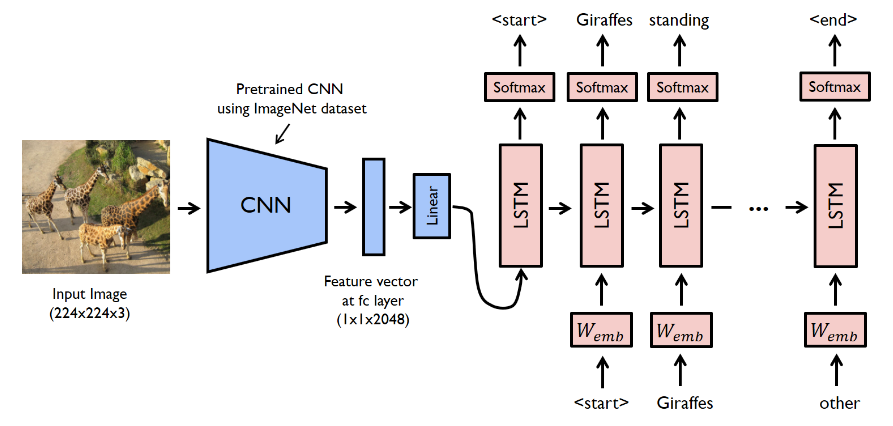

### Encoder

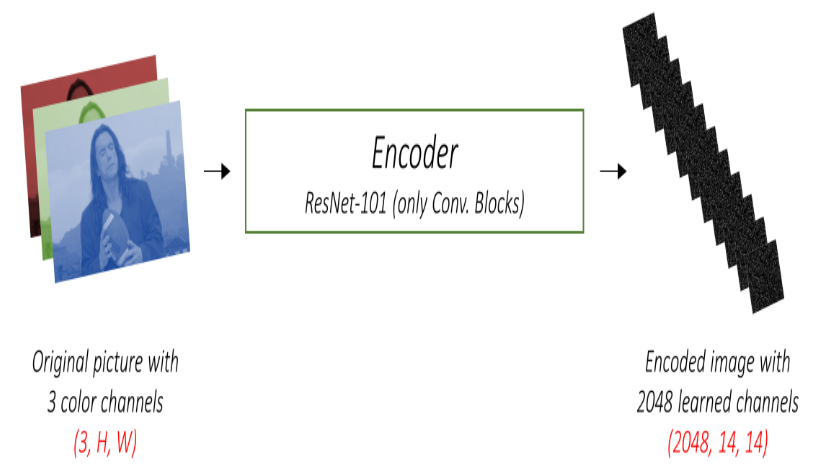

### Decoder

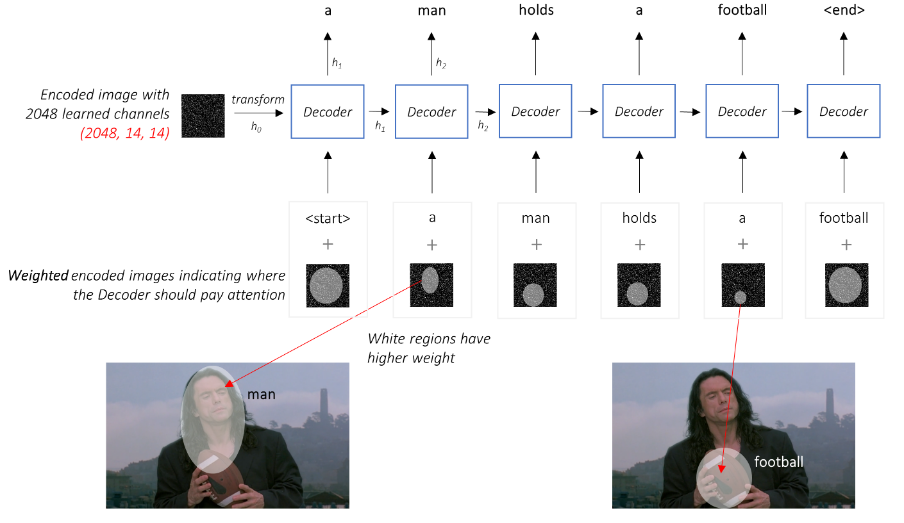

## Embed Attention Mechanism

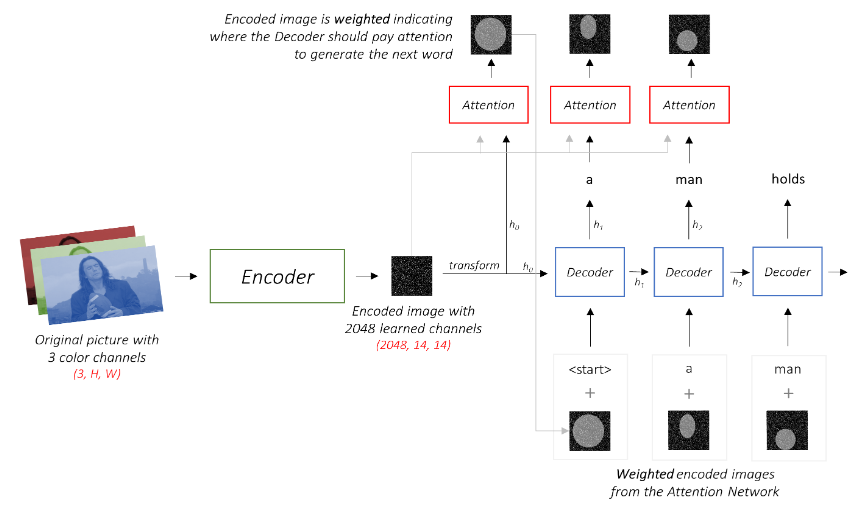

## Inference
- 첫 번째 디코드 단계에서는 상위 k개의 후보를 고려합니다. 이러한 k개의 첫 번째 단어 각각에 대해 k개의 두 번째 단어를 생성합니다.
- 가산점수를 고려하여 상위 k개 [첫 번째 단어, 두 번째 단어] 조합을 선택합니다.
- k개의 두 번째 단어 각각에 대해 k개의 세 번째 단어를 선택하고, 상위 k개의 [첫 번째 단어, 두 번째 단어, 세 번째 단어] 조합을 선택합니다.
- 각 디코드 단계에서 반복합니다. k개의 시퀀스가 ​​종료된 후 전체 점수가 가장 높은 시퀀스를 선택합니다.

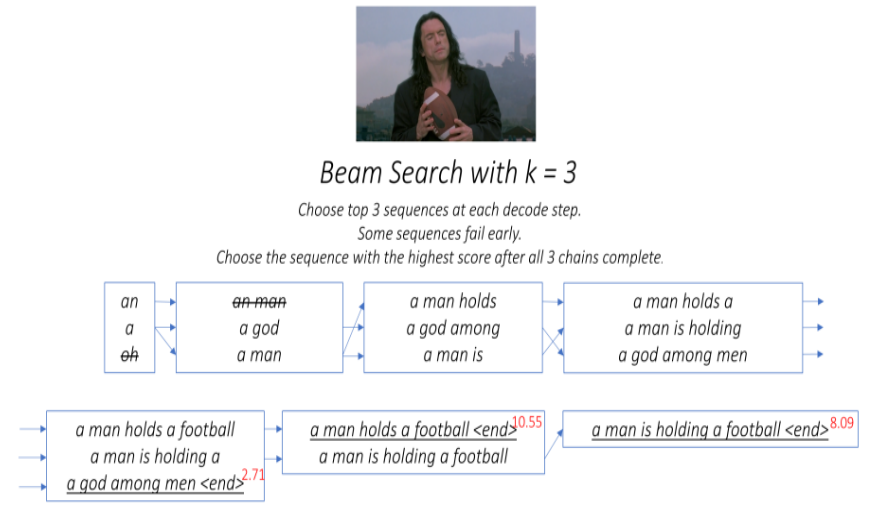

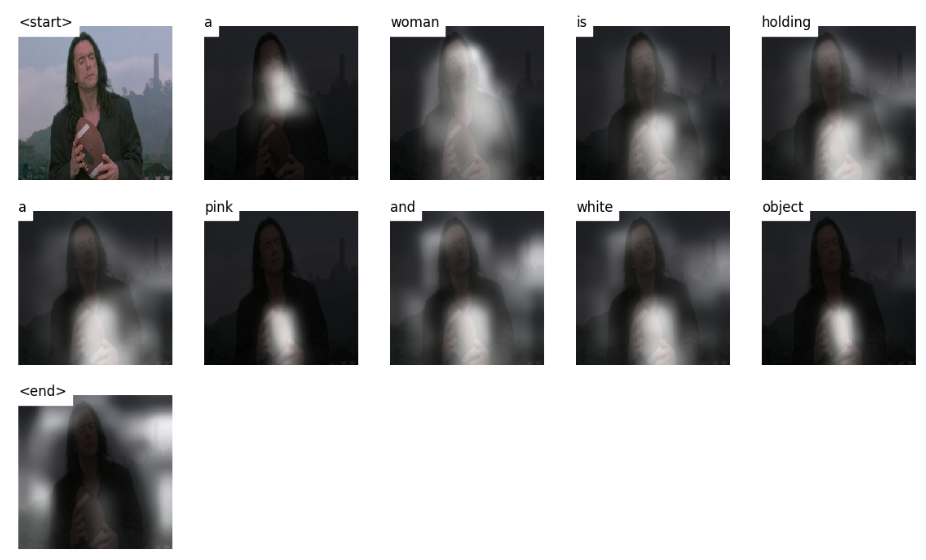

# [Flickr 8k Dataset 예제](https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch)

## [Loading the Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k/data)

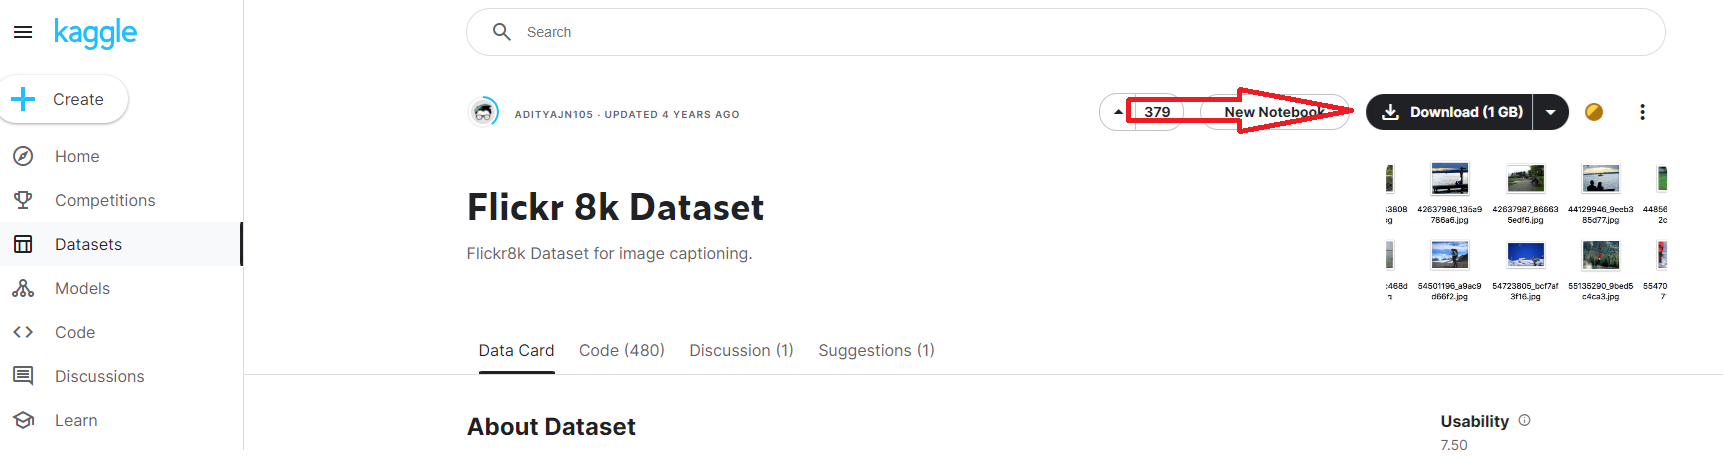

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    data_location = "/content/data/MyDrive/google_lecture1/06. deep learning/4. Vision-NLP Pytorch/data/flickr 8k"
except:
    data_location = "./data/flickr 8k"

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


## Exploring the dataset

In [ ]:
#reading the text data
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...

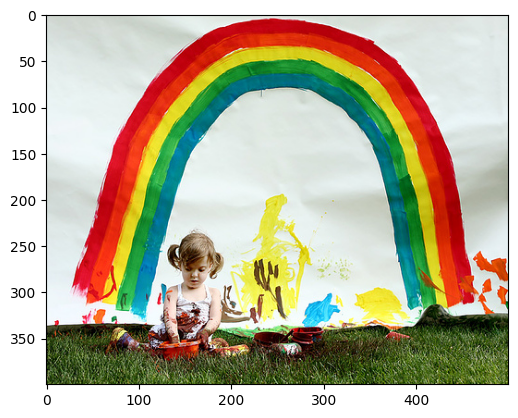

Caption: A little girl is sitting in front of a large painted rainbow .
Caption: A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption: There is a girl with pigtails sitting in front of a rainbow painting .
Caption: Young girl with pigtails painting outside in the grass .
Caption: A man lays on a bench while his dog sits by him .


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

## Writing the custom dataset

In [ ]:
import os
from collections import Counter
import spacy
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from tqdm import tqdm
from PIL import Image

In [ ]:
#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:
class Vocabulary:

    def __init__(self,freq_threshold):
        self.spacy_eng = spacy.load("en_core_web_sm")
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:'<PAD>',1:'<SOS>',2:'<EOS>',3:'<UNK>'}
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    def tokenize(self, text):
        return [token.text.lower() for token in self.spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                # add the word to the vocab if it reaches minum frequecy threshold
                # word가 self.freq_threshold 이상 존재한다면, vocab에 등록
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [ ]:
#testing the vicab class
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


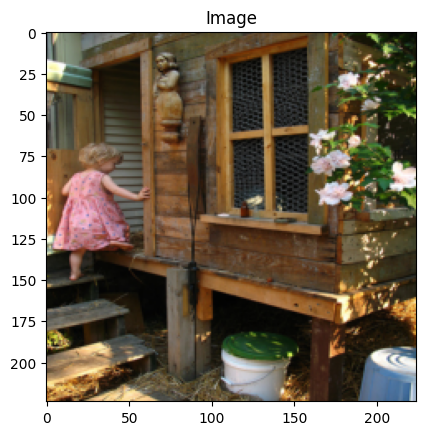

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)



img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

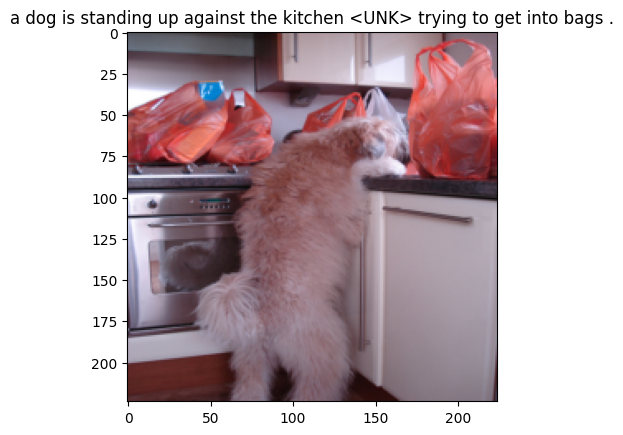

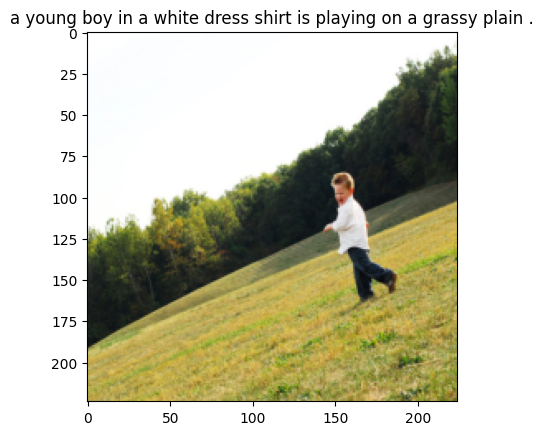

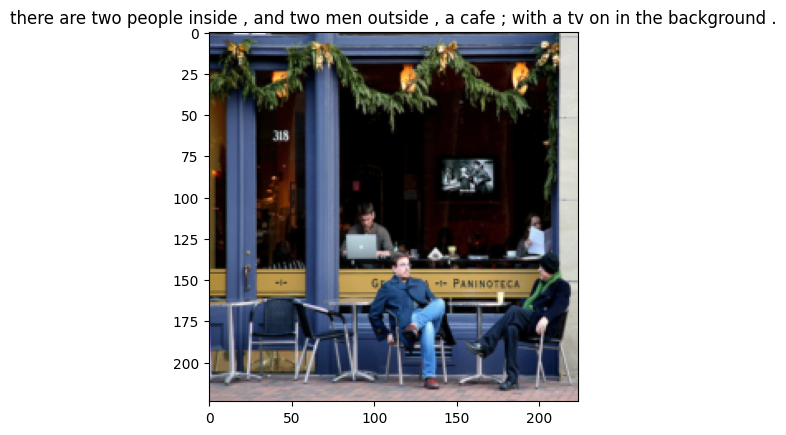

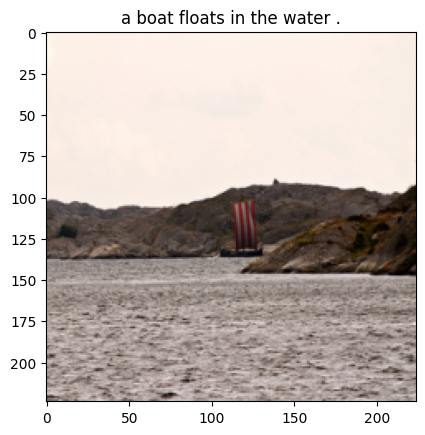

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

## Implementing the Helper function to plot the Tensor image

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Defining the Model Architecture

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        # resnet 모델에서 마지막 예측부분 제거 -> 즉, resnet 학습 블럭만 사용함
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)


    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)


        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha,attention_weights


In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Setting Hypperparameter and Init the model

In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [ ]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

## Training Job from above configs

In [ ]:
num_epochs = 10 #25
print_every = 5000

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    for idx, (image, captions) in enumerate(tqdm(data_loader, 'training', total=len(data_loader))):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            model.train()

    #save the latest model
    save_model(model,epoch)

Output hidden; open in https://colab.research.google.com to view.

## Visualizing the attentions

In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)

    return caps,alphas

In [ ]:
#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())


    plt.tight_layout()
    plt.show()

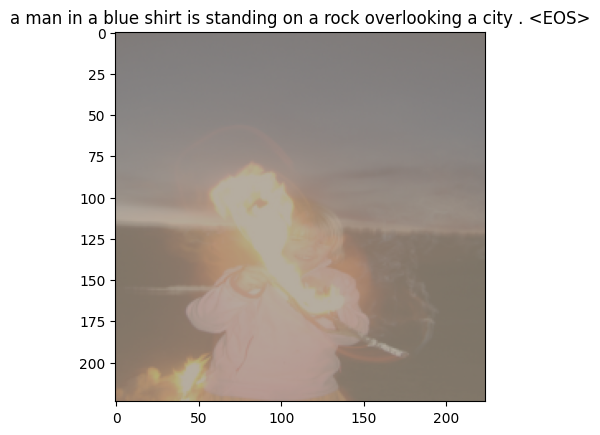

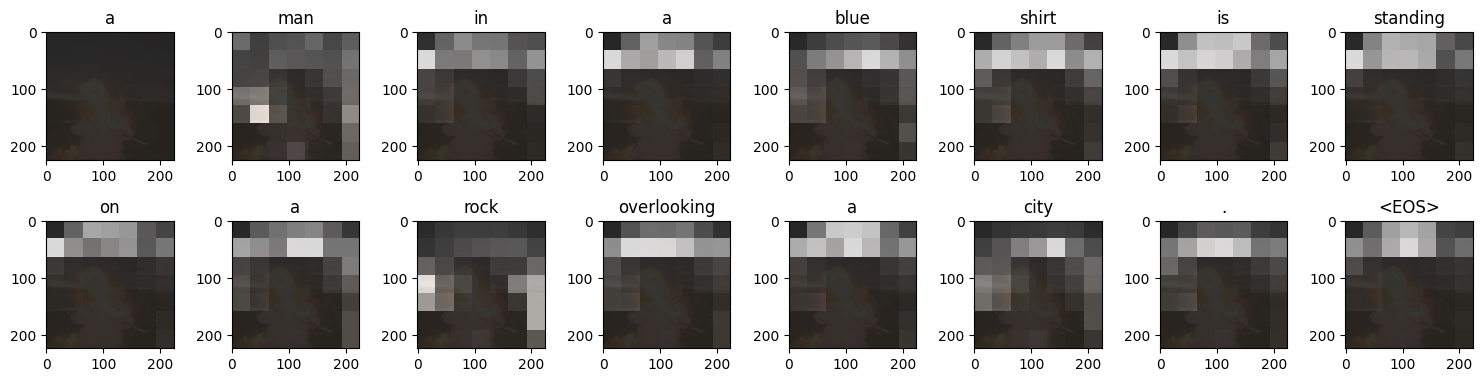

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

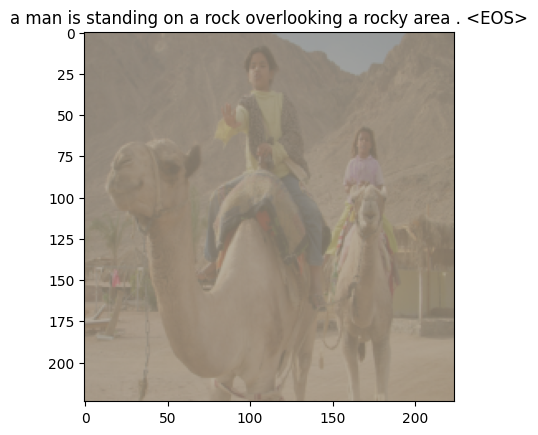

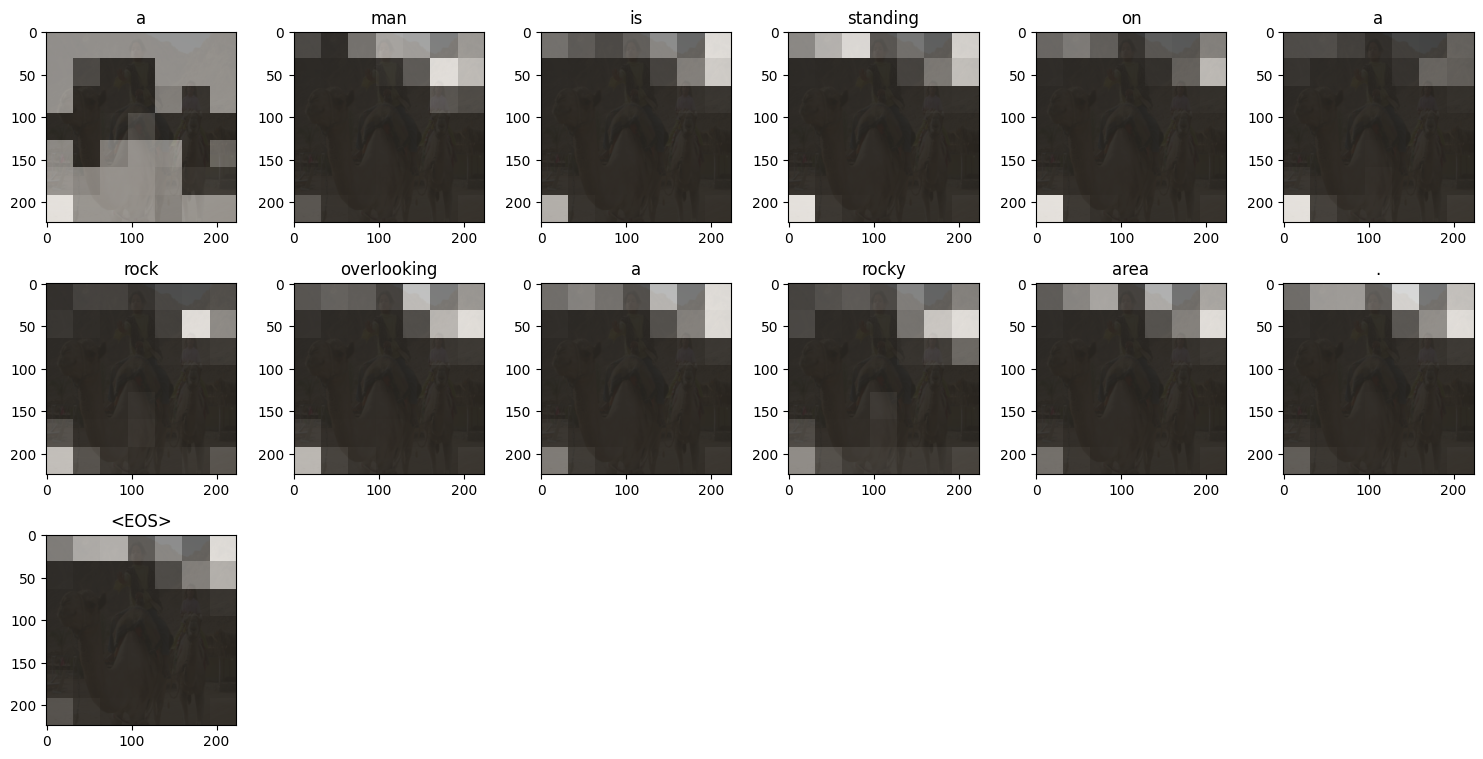

In [ ]:
#show any 1
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

# [COCO 2014 dataset 예제](https://thepythoncode.com/article/image-captioning-with-pytorch-and-transformers-in-python)

In [ ]:
!pip install torch transformers rouge_score evaluate datasets

In [ ]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm
# set device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

## Using a Trained Model

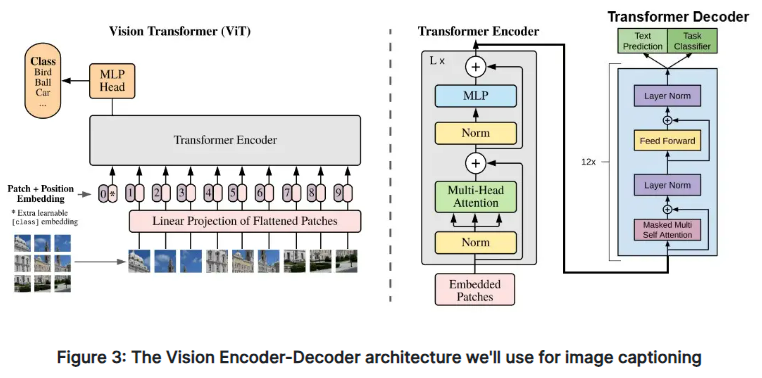

In [ ]:
# load a fine-tuned image captioning model and corresponding tokenizer and image processor
finetuned_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
finetuned_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
finetuned_image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpconnect--vit-gpt2-image-captioning/snapshots/dc68f91c06a1ba6f15268e5b9c13ae7a7c514084/config.json
Model config VisionEncoderDecoderConfig {
  "_name_or_path": "vit-gpt-pt",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "bos_token_id": 50256,
  "decoder": {
    "_name_or_path": "",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": 50256,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bo

In [ ]:
import urllib.parse as parse
import os

# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

# a function to perform inference
def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)
    # preprocess the image
    attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0]])
    img = image_processor(image, return_tensors="pt", attention_mask=attention_mask).to(device)
    # generate the caption (using greedy decoding by default)
    output = model.generate(**img)
    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

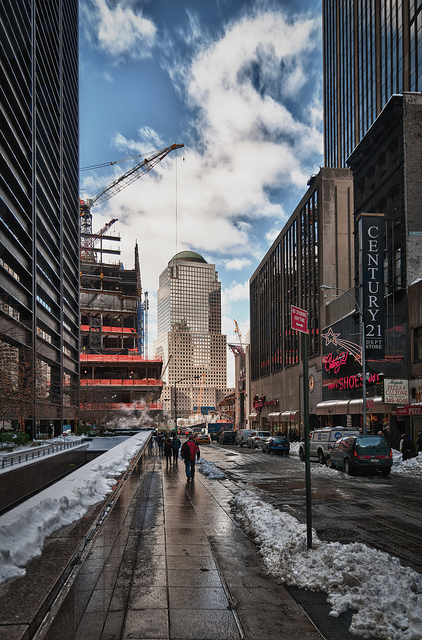

Unused or unrecognized kwargs: attention_mask.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


'a person walking down a street with a snow covered sidewalk '

In [ ]:
# load displayer
from IPython.display import display

url = "http://images.cocodataset.org/test-stuff2017/000000009384.jpg"
# display the image
display(load_image(url))
# get the caption
get_caption(finetuned_model, finetuned_image_processor, finetuned_tokenizer, url)

## Train your Own Image Captioning Model

### Loading the Model

In [ ]:
# the encoder model that process the image and return the image features
# encoder_model = "WinKawaks/vit-small-patch16-224"
# encoder_model = "google/vit-base-patch16-224"
# encoder_model = "google/vit-base-patch16-224-in21k"
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
# the decoder model that process the image features and generate the caption text
# decoder_model = "bert-base-uncased"
# decoder_model = "prajjwal1/bert-tiny"
decoder_model = "gpt2"
# load the model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
    "rose_window, rosette": 9916,
    "roseate_spoonbill, Ajaia_ajaja": 1912,
    "rosebay, Rhododendron_maxima": 19033,
    "rosebud": 17526,
    "rosebud_cherry, winter_flowering_cherry, Prunus_subhirtella": 20120,
    "rosebud_orchid, Cleistes_rosea, Pogonia_rosea": 18520,
    "rosefish, ocean_perch, Sebastodes_marinus": 4079,
    "roselle, rozelle, sorrel, red_sorrel, Jamaica_sorrel, Hibiscus_sabdariffa": 18887,
    "rosemary": 13339,
    "rosemary, Rosmarinus_officinalis": 20711,
    "rosewood, rosewood_tree": 19778,
    "rosilla, Helenium_puberulum": 18324,
    "rosin_bag": 9917,
    "rosinweed, Silphium_laciniatum": 18422,
    "rosita, Centaurium_calycosum": 19186,
    "rosy_boa, Lichanura_trivirgata": 1199,
    "rotary_actuator, positioner": 9918,
    "rotary_engine": 9919,
    "rotary_press": 9920,
    "rotating_mechanism": 9921,
    "rotating_shaft, shaft": 9922,
    "rotavirus": 258,
    "rotgut": 13998,
    "rotifer": 1728,
    "rotisseri

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/model.safetensors
Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of SwinModel were initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k.
If your task is similar to the task the model of the

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_vers

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bia

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config
Generate config GenerationConfig {}



### load our image_processor and tokenizer

In [ ]:
# initialize the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(decoder_model)
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
# tokenizer = BertTokenizerFast.from_pretrained(decoder_model)
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



### tokenizer
- Before proceeding, we have to make sure that the `decoder_start_token_id` and `pad_token_id` are present in our model configuration. Therefore, we have to manually set them using the `tokenizer` config

In [ ]:
if "gpt2" in decoder_model:
  # gpt2 does not have decoder_start_token_id and pad_token_id
  # but has bos_token_id and eos_token_id
  tokenizer.pad_token = tokenizer.eos_token # pad_token_id as eos_token_id
  model.config.eos_token_id = tokenizer.eos_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  # set decoder_start_token_id as bos_token_id
  model.config.decoder_start_token_id = tokenizer.bos_token_id
else:
  # set the decoder start token id to the CLS token id of the tokenizer
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  # set the pad token id to the pad token id of the tokenizer
  model.config.pad_token_id = tokenizer.pad_token_id

Here is a definition of each special token defined above:
- `bos_token_id` is the ID of the token that represents the beginning of the sentence.
- `eos_token_id` is the ID of the token that represents the end of the sentence.
- `decoder_start_token_id` is used to indicate the starting point of the decoder to start generating the target sequence (in our case, the caption).
- `pad_token_id` is used to pad short sequences of text into a fixed length.
- `cls_token_id` represents the classification token and is typically used by BERT and other tokenizers as the first token in a sequence of text before the actual sentence starts.

The GPT2 tokenizer does not have the `pad_token_id` and `decoder_start_token_id` but it has `bos_token_id` and `eos_token_id`. Therefore, we can simply set the `pad_token` as the `eos_token` and `decoder_start_token_id` as the `bos_token_id`.

### Downloading & Loading the Dataset

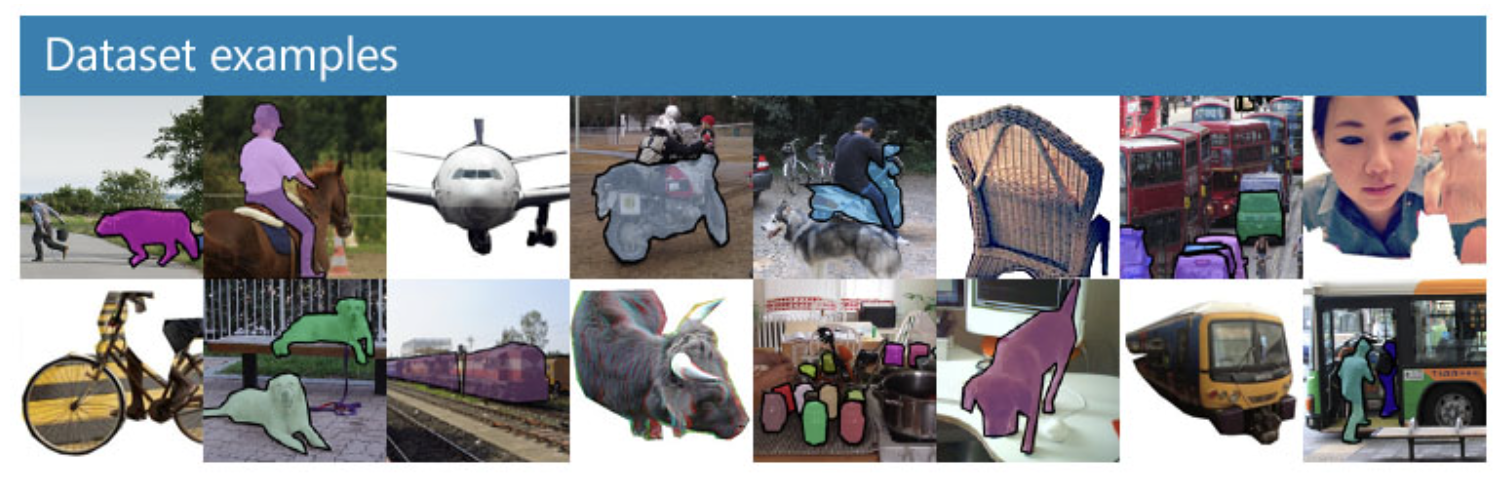

In [ ]:
from datasets import load_dataset

max_length = 32 # max length of the captions in tokens
coco_dataset_ratio = 50 # 50% of the COCO2014 dataset
train_ds = load_dataset("HuggingFaceM4/COCO", split=f"train[:{coco_dataset_ratio}%]")
valid_ds = load_dataset("HuggingFaceM4/COCO", split=f"validation[:{coco_dataset_ratio}%]")
test_ds = load_dataset("HuggingFaceM4/COCO", split="test")
len(train_ds), len(valid_ds), len(test_ds)

The repository for HuggingFaceM4/COCO contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HuggingFaceM4/COCO.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

(283374, 12505, 25010)

In [ ]:
import numpy as np

# remove the images with less than 3 dimensions (possibly grayscale images)
train_ds = train_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)
valid_ds = valid_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)
test_ds = test_ds.filter(lambda item: np.array(item["image"]).ndim in [3, 4], num_proc=2)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Filter (num_proc=2):   0%|          | 0/283374 [00:00<?, ? examples/s]

In [ ]:
def preprocess(items):
  # preprocess the image
  pixel_values = image_processor(items["image"], return_tensors="pt").pixel_values.to(device)
  # tokenize the caption with truncation and padding
  targets = tokenizer([ sentence["raw"] for sentence in items["sentences"] ],
                      max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
  return {'pixel_values': pixel_values, 'labels': targets["input_ids"]}

# using with_transform to preprocess the dataset during training
train_dataset = train_ds.with_transform(preprocess)
valid_dataset = valid_ds.with_transform(preprocess)
test_dataset  = test_ds.with_transform(preprocess)

In [ ]:
# a function we'll use to collate the batches
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

### Using PyTorch Training Loop

In [ ]:
num_epochs = 2 # number of epochs
batch_size = 16 # the size of batches

In [ ]:
# alternative way of training: pytorch loop
from torch.utils.data import DataLoader

# define our data loaders
train_dataset_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)

In [ ]:
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir ./image-captioning/tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

summary_writer = SummaryWriter(log_dir="./image-captioning/tensorboard")
# print some statistics before training
# number of training steps
n_train_steps = num_epochs * len(train_dataset_loader)
# number of validation steps
n_valid_steps = len(valid_dataset_loader)
# current training step
current_step = 0
# logging, eval & save steps
save_steps = 1000

In [ ]:
import evaluate

# load the rouge and bleu metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
  preds = eval_pred.label_ids
  labels = eval_pred.predictions
  # decode the predictions and labels
  pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # compute the rouge score
  rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
  # multiply by 100 to get the same scale as the rouge score
  rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}
  # compute the bleu score
  bleu_result = bleu.compute(predictions=pred_str, references=labels_str)
  # get the length of the generated captions
  generation_length = bleu_result["translation_length"]
  return {
        **rouge_result,
        "bleu": round(bleu_result["bleu"] * 100, 4),
        "gen_len": bleu_result["translation_length"] / len(preds)
  }

In [ ]:
for epoch in range(num_epochs):
    # set the model to training mode
    model.train()
    # initialize the training loss
    train_loss = 0
    for batch in tqdm(train_dataset_loader, "Training", total=len(train_dataset_loader), leave=False):
      if current_step % save_steps == 0:
        ### evaluation code ###
        # evaluate on the validation set
        # if the current step is a multiple of the save steps
        print(f"\nValidation at step {current_step}...\n")
        # set the model to evaluation mode
        model.eval()
        # initialize our lists that store the predictions and the labels
        predictions, labels = [], []
        # initialize the validation loss
        valid_loss = 0
        for batch in valid_dataset_loader:
            # get the batch
            pixel_values = batch["pixel_values"]
            label_ids = batch["labels"]
            # forward pass
            outputs = model(pixel_values=pixel_values, labels=label_ids)
            # get the loss
            loss = outputs.loss
            valid_loss += loss.item()
            # free the GPU memory
            logits = outputs.logits.detach().cpu()
            # add the predictions to the list
            predictions.extend(logits.argmax(dim=-1).tolist())
            # add the labels to the list
            labels.extend(label_ids.tolist())
        # make the EvalPrediction object that the compute_metrics function expects
        eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
        # compute the metrics
        metrics = compute_metrics(eval_prediction)
        # print the stats
        print(f"\nEpoch: {epoch}, Step: {current_step}, Train Loss: {train_loss / save_steps:.4f}, " +
              f"Valid Loss: {valid_loss / n_valid_steps:.4f}, BLEU: {metrics['bleu']:.4f}, " +
              f"ROUGE-1: {metrics['rouge1']:.4f}, ROUGE-2: {metrics['rouge2']:.4f}, ROUGE-L: {metrics['rougeL']:.4f}\n")
        # log the metrics
        summary_writer.add_scalar("valid_loss", valid_loss / n_valid_steps, global_step=current_step)
        summary_writer.add_scalar("bleu", metrics["bleu"], global_step=current_step)
        summary_writer.add_scalar("rouge1", metrics["rouge1"], global_step=current_step)
        summary_writer.add_scalar("rouge2", metrics["rouge2"], global_step=current_step)
        summary_writer.add_scalar("rougeL", metrics["rougeL"], global_step=current_step)
        # save the model
        model.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        tokenizer.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        image_processor.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        # get the model back to train mode
        model.train()
        # reset the train and valid loss
        train_loss, valid_loss = 0, 0
      ### training code below ###
      # get the batch & convert to tensor
      pixel_values = batch["pixel_values"]
      labels = batch["labels"]
      # forward pass
      outputs = model(pixel_values=pixel_values, labels=labels)
      # get the loss
      loss = outputs.loss
      # backward pass
      loss.backward()
      # update the weights
      optimizer.step()
      # zero the gradients
      optimizer.zero_grad()
      # log the loss
      loss_v = loss.item()
      train_loss += loss_v
      # increment the step
      current_step += 1
      # log the training loss
      summary_writer.add_scalar("train_loss", loss_v, global_step=current_step)

In [ ]:
# load the best model, change the checkpoint number to the best checkpoint
# if the last checkpoint is the best, then ignore this cell
best_checkpoint = 3000
best_model = VisionEncoderDecoderModel.from_pretrained(f"./image-captioning/checkpoint-{best_checkpoint}").to(device)

In [ ]:
def get_evaluation_metrics(model, dataset):
  model.eval()
  # define our dataloader
  dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size)
  # number of testing steps
  n_test_steps = len(dataloader)
  # initialize our lists that store the predictions and the labels
  predictions, labels = [], []
  # initialize the test loss
  test_loss = 0.0
  for batch in tqdm(dataloader, "Evaluating"):
      # get the batch
      pixel_values = batch["pixel_values"]
      label_ids = batch["labels"]
      # forward pass
      outputs = model(pixel_values=pixel_values, labels=label_ids)
      # outputs = model.generate(pixel_values=pixel_values, max_length=max_length)
      # get the loss
      loss = outputs.loss
      test_loss += loss.item()
      # free the GPU memory
      logits = outputs.logits.detach().cpu()
      # add the predictions to the list
      predictions.extend(logits.argmax(dim=-1).tolist())
      # add the labels to the list
      labels.extend(label_ids.tolist())
  # make the EvalPrediction object that the compute_metrics function expects
  eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
  # compute the metrics
  metrics = compute_metrics(eval_prediction)
  # add the test_loss to the metrics
  metrics["test_loss"] = test_loss / n_test_steps
  return metrics

In [ ]:
# 메모리부족
# metrics = get_evaluation_metrics(best_model, test_dataset)
# metrics

In [ ]:
# 메모리부족
# get_evaluation_metrics(finetuned_model, test_dataset)

In [ ]:
# using the pipeline API
image_captioner = pipeline("image-to-text", model="Abdou/vit-swin-base-224-gpt2-image-captioning")
image_captioner.model = image_captioner.model.to(device)

In [ ]:
# 메모리부족
# get_evaluation_metrics(image_captioner.model, test_dataset)

### Performing Inference

In [ ]:
def show_image_and_captions(url):
  # get the image and display it
  display(load_image(url))
  # get the captions on various models
  our_caption = get_caption(best_model, image_processor, tokenizer, url)
  finetuned_caption = get_caption(finetuned_model, finetuned_image_processor, finetuned_tokenizer, url)
  pipeline_caption = get_caption(image_captioner.model, image_processor, tokenizer, url)
  # print the captions
  print(f"Our caption: {our_caption}")
  print(f"nlpconnect/vit-gpt2-image-captioning caption: {finetuned_caption}")
  print(f"Abdou/vit-swin-base-224-gpt2-image-captioning caption: {pipeline_caption}")

In [ ]:
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000000001.jpg")